# Notebook 04 - TFIDF + Logistic Regression

## Setup

In [117]:
# --- Configture Notebook ------
# show all outputs of cell
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import black
import jupyter_black

jupyter_black.load(
    lab=True,
    line_length=100,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

# enable automatic reloading
%load_ext autoreload
%autoreload 2

from pathlib import Path

from pandas.core.base import PandasObject
from arxiv_article_classifier.utils import display_fully

PandasObject.display_fully = display_fully

DATAFOLDER = Path().cwd().parent / "data"
FIGUREFOLDER = Path().cwd().parent / "reports" / "figures"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
DATAFOLDER_PROCESSED = DATAFOLDER / "processed" / "tfidf-model"

from arxiv_article_classifier.data.load import load_processed_data, load_taxonomy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier

In [57]:
# load dataset
(
    (X_train, X_val, _, y_train, y_val, _),
    labels,
) = load_processed_data(DATAFOLDER_PROCESSED)

# load taxonomy
taxonomy = load_taxonomy(DATAFOLDER / "raw" / "taxonomy.pkl")

In [58]:
vectorizer = TfidfVectorizer()

X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)

In [116]:
clf = MultiOutputClassifier(LogisticRegression()).fit(X_train_tfidf, y_train)

print("Performance on Train")
y_train_pred = clf.predict(X_train_tfidf)
print(classification_report(y_train, list(y_train_pred)))

print("Performance on Validation")
y_val_pred = clf.predict(X_val_tfidf)

print(classification_report(y_val, list(y_val_pred)))

Performance on Train
              precision    recall  f1-score   support

           0       0.91      0.71      0.80      2516
           1       0.92      0.68      0.78      2471
           2       0.89      0.52      0.66      1926
           3       0.92      0.69      0.79      1829
           4       0.84      0.57      0.68      5987
           5       0.87      0.47      0.61      1800
           6       0.95      0.68      0.79      2159
           7       0.91      0.63      0.74      1831
           8       0.98      0.81      0.88      1801
           9       0.93      0.54      0.68      1900
          10       0.86      0.40      0.55      2103
          11       0.95      0.71      0.81      1831
          12       0.89      0.48      0.62      2146
          13       0.95      0.71      0.81      1804

   micro avg       0.90      0.61      0.73     32104
   macro avg       0.91      0.61      0.73     32104
weighted avg       0.90      0.61      0.72     32104
 samp

/home/walkenho/.cache/pypoetry/virtualenvs/arxiv-article-classifier-IjPt3q2a-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/home/walkenho/.cache/pypoetry/virtualenvs/arxiv-article-classifier-IjPt3q2a-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



Add some weight rebalancing to account for imbalanced data.

In [60]:
clf = MultiOutputClassifier(LogisticRegression(class_weight="balanced")).fit(X_train_tfidf, y_train)

print("Performance on Train")
y_train_pred = clf.predict(X_train_tfidf)
print(classification_report(y_train, list(y_train_pred)))

print("Performance on Validation")
y_val_pred = clf.predict(X_val_tfidf)

print(classification_report(y_val, list(y_val_pred)))

Performance on Train
              precision    recall  f1-score   support

           0       0.74      0.99      0.85      2516
           1       0.74      0.97      0.84      2471
           2       0.60      0.98      0.75      1926
           3       0.77      0.99      0.87      1829
           4       0.69      0.86      0.76      5987
           5       0.60      0.98      0.75      1800
           6       0.77      0.99      0.86      2159
           7       0.69      0.98      0.81      1831
           8       0.93      1.00      0.96      1801
           9       0.68      0.98      0.80      1900
          10       0.57      0.98      0.72      2103
          11       0.74      0.99      0.85      1831
          12       0.59      0.97      0.73      2146
          13       0.74      0.99      0.84      1804

   micro avg       0.69      0.96      0.80     32104
   macro avg       0.70      0.97      0.81     32104
weighted avg       0.70      0.96      0.81     32104
 samp

/home/walkenho/.cache/pypoetry/virtualenvs/arxiv-article-classifier-IjPt3q2a-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.

/home/walkenho/.cache/pypoetry/virtualenvs/arxiv-article-classifier-IjPt3q2a-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.



In [61]:
from collections import Counter
import plotly.express as px
import pandas as pd
import numpy as np


n_labels = []
n_instances = []

for k, v in Counter([prediction.sum() for prediction in y_val_pred]).items():
    n_labels.append(k)
    n_instances.append(v)
n_instances = np.array(n_instances) / sum(n_instances)

fig = px.bar(
    pd.DataFrame({"n_tags": n_labels, "n_instances_[%]": n_instances}),
    x="n_tags",
    y="n_instances_[%]",
)


# save_image(fig, FIGUREFOLDER, filename="nb04-fig1-how-many-tags-per-message-without-rebalancing")
fig.show()

This is a quite different distribution from the original distribution that we wanted to recover. We clearly predict too many tags (as can be seen from the high recall, but not as high precision in the metric report, too).

Let's see where particular issues are.

In [62]:
import pandas as pd

(
    (_, X_val_raw, _, _, _, _),
    _,
) = load_processed_data(DATAFOLDER / "interim")

comparison = pd.DataFrame(y_val_pred - y_val, columns=labels).assign(
    message_raw=X_val_raw, message_cleaned=X_val
)

comparison.head()

,cs.CL,cs.CV,cs.CY,cs.GT,cs.LG,cs.MA,cs.RO,cs.SI,eess.AS,eess.SP,eess.SY,math.NA,math.OC,math.ST,message_raw,message_cleaned
0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,"In this paper, we propose a simulation model o...",paper propose simulation model spacetime discr...
1,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,"This paper introduces a blazingly fast, no-los...",paper introduce blazingly fast loss expert sys...
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Decentralized multi-robot systems typically pe...,decentralized multi robot system typically per...
3,0,0,0,-1,0,-1,0,0,0,0,-1,0,0,0,As one of the main subjects of investigation i...,one main subject investigation datum science n...
4,0,0,0,0,-1,0,0,0,0,0,0,0,0,0,Partially Observable Stochastic Games (POSGs) ...,partially observable stochastic games posgs ge...


In [63]:
loi = labels[0]
taxonomy[loi]

comparison[comparison[loi] != 0][[loi, "message_raw", "message_cleaned"]].head(20).display_fully()

'Computation and Language'

,cs.CL,message_raw,message_cleaned
175,-1,"This paper introduces the SEAD framework that simplifies the process of\ndesigning and describing autonomous vehicle platooning manoeuvres. Although a\nlarge body of research has been formulating platooning manoeuvres, it is still\nchallenging to design, describe, read, and understand them. This difficulty\nlargely arises from missing formalisation. To fill this gap, we analysed\nexisting ways of describing manoeuvres, derived the causes of difficulty, and\ndesigned a framework that simplifies the manoeuvre design process. Alongside, a\nManoeuvre Design Language was developed to structurally describe manoeuvres in\na machine-readable format. Unlike state-of-the-art manoeuvre descriptions that\nrequire one state machine for every participating vehicle, the SEAD framework\nallows describing any manoeuvre from the single perspective of the platoon\nleader. %As a proof of concept, the proposed framework was implemented in the\nmixed traffic simulation environment BEHAVE for an autonomous highway scenario.\nUsing this framework, we implemented several manoeuvres as they were described\nin literature. To demonstrate the applicability of the framework, an experiment\nwas performed to evaluate the execution time performance of multiple\nalternatives of the Join-Middle manoeuvre. This proof-of-concept experiment\nrevealed that the manoeuvre execution time can be reduced by 28 \% through\nparallelising various steps without considerable secondary effects. We hope\nthat the SEAD framework will pave the way for further research in the area of\nnew manoeuvre design and optimisation by largely simplifying and unifying\nplatooning manoeuvre representation.",paper introduce sead framework simplify process design describe autonomous vehicle platoone manoeuvre although large body research formulate platoone manoeuvre still challenge design describe read understand difficulty largely arise miss formalisation fill gap analyse exist way describe manoeuvre derive cause difficulty design framework simplify manoeuvre design process alongside manoeuvre design language develop structurally describe manoeuvre machine readable format unlike state art manoeuvre description require one state machine every participate vehicle sead framework allow describe manoeuvre single perspective platoon leader proof concept propose framework implement mixed traffic simulation environment behave autonomous highway scenario use framework implement several manoeuvre describe literature demonstrate applicability framework experiment perform evaluate execution time performance multiple alternative join middle manoeuvre proof concept experiment reveal manoeuvre execution time reduce 28 parallelise various step without considerable secondary effect hope sead framework pave way research area new manoeuvre design optimisation largely simplify unifying platoone manoeuvre representation
266,-1,"Successful negotiators must learn how to balance optimizing for self-interest\nand cooperation. Yet current artificial negotiation agents often heavily depend\non the quality of the static datasets they were trained on, limiting their\ncapacity to fashion an adaptive response balancing self-interest and\ncooperation. For this reason, we find that these agents can achieve either high\nutility or cooperation, but not both. To address this, we introduce a targeted\ndata acquisition framework where we guide the exploration of a reinforcement\nlearning agent using annotations from an expert oracle. The guided exploration\nincentivizes the learning agent to go beyond its static dataset and develop new\nnegotiation strategies. We show that this enables our agents to obtain\nhigher-reward and more Pareto-optimal solutions when negotiating with both\nsimulated and human partners compared to standard supervised learning and\nreinforcement learning methods. This trend additionally holds when comparing\nagents using our targeted data acquisition framework to 

/tmp/ipykernel_7473/685067783.py:46: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



,Computation and Language,Computer Vision and Pattern Recognition,Computers and Society,Computer Science and Game Theory,Machine Learning,Multiagent Systems,Robotics,Social and Information Networks,Audio and Speech Processing,Signal Processing,Systems and Control,Numerical Analysis,Optimization and Control,Statistics Theory
0,model,image,datum,game,learning,agent,robot,network,speech,propose,system,method,problem,distribution
1,language,dataset,fairness,agent,neural,multi,task,graph,model,signal,control,numerical,optimization,datum
2,task,method,ai,mechanism,model,system,robotic,social,audio,base,propose,equation,control,estimator
3,text,video,use,equilibrium,learn,problem,use,user,use,performance,network,scheme,algorithm,sample
4,speech,object,bias,strategy,datum,base,environment,node,propose,datum,use,error,optimal,study


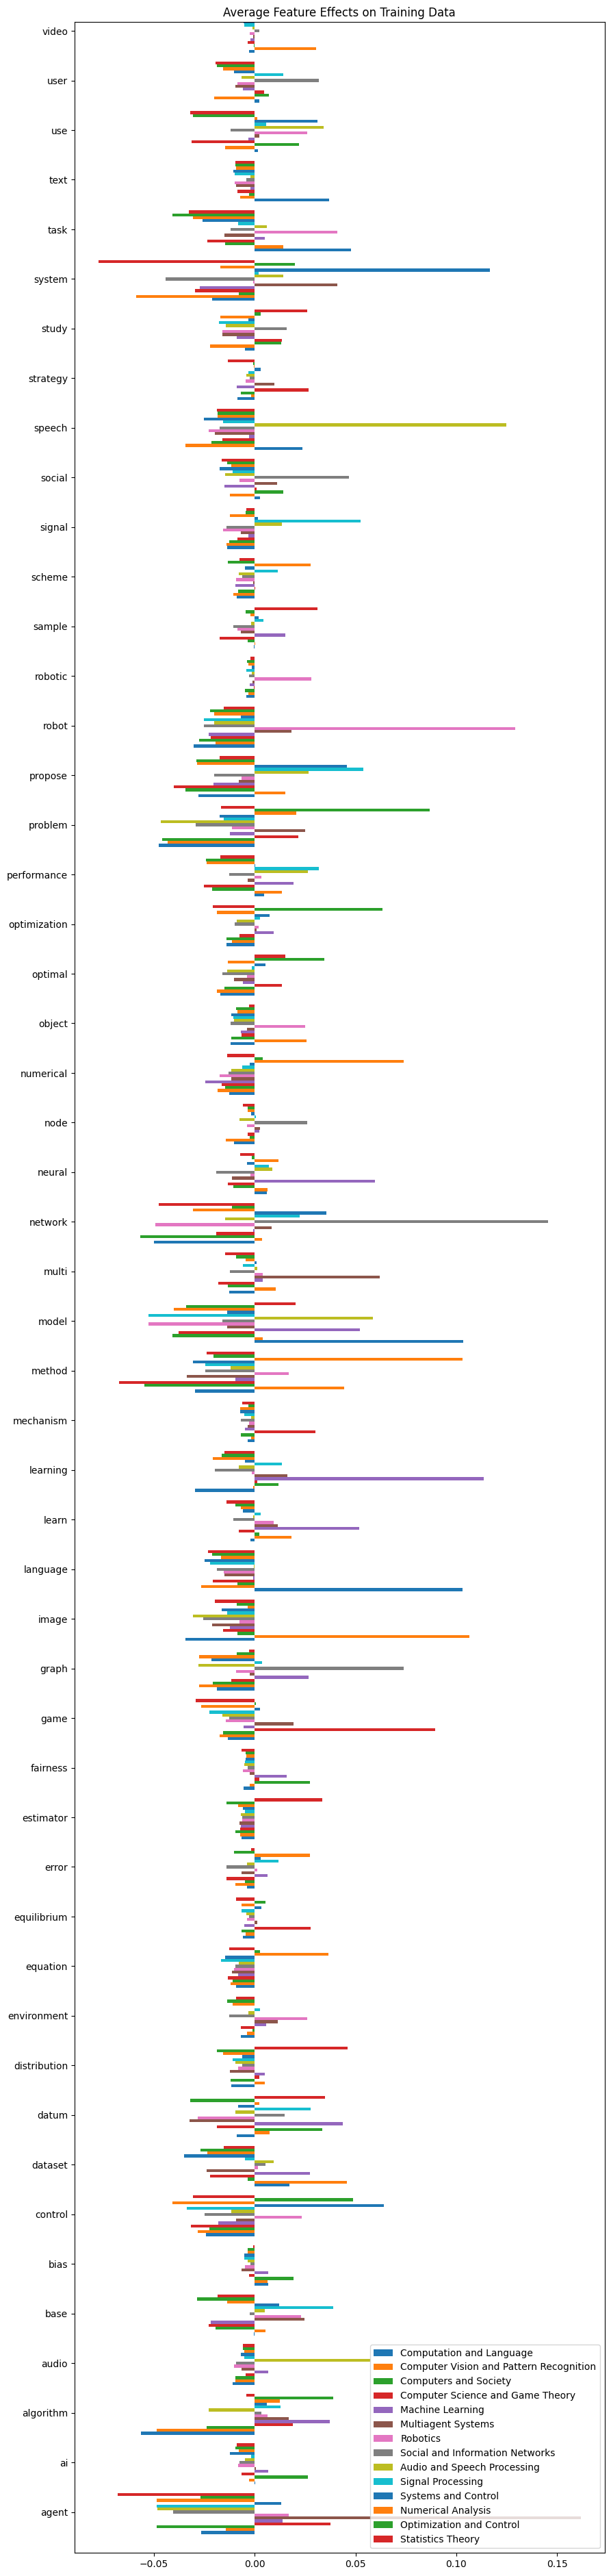

In [118]:
import matplotlib.pyplot as plt

n_categories = 14
feature_names = vectorizer.get_feature_names_out()

average_feature_effects = [
    (clf.estimators_[i].coef_ * np.asarray(X_train_tfidf.mean(axis=0)).ravel())
    for i in range(n_categories)
]

for i, label in enumerate(labels):
    top5 = np.argsort(average_feature_effects[i][0])[-5:][::-1]
    if i == 0:
        top = pd.DataFrame(feature_names[top5], columns=[taxonomy[label]])
        top_indices = top5
    else:
        top[taxonomy[label]] = feature_names[top5]
        top_indices = np.concatenate((top_indices, top5), axis=None)
top_indices = np.unique(top_indices)
predictive_words = feature_names[top_indices]

# plot feature effects
bar_size = 0.25
padding = 0.75
y_locs = np.arange(len(top_indices)) * (n_categories * bar_size + padding)

fig, ax = plt.subplots(figsize=(10, 48))
for i, label in enumerate(labels):
    _ = ax.barh(
        y_locs + (i - n_categories / 2) * bar_size,
        average_feature_effects[i][0][top_indices],
        height=bar_size,
        label=taxonomy[label],
    )
    _ = ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - n_categories * bar_size,
            len(top_indices) * (n_categories * bar_size + padding) - n_categories * bar_size,
        ],
    )
    _ = ax.legend(loc="lower right")
    _ = ax.set_title("Average Feature Effects on Training Data")

fig.show()
fig.savefig(FIGUREFOLDER / "feature-importance-tfidf.png")

top